In [1]:
#%%appyter init
from appyter import magic
magic.init(lambda _=globals: _())

In [2]:
%%appyter hide_code
{% do SectionField(
    name='PRIMARY',
    title='Enrichr Consensus Terms',
    subtitle='This appyter returns consensus Enrichr terms using a set of gene sets',
    img='enrichr.png'
) %}

In [3]:
%%appyter code_exec

{% set title = StringField(
    name='title',
    label='Notebook name',
    default='Enrichr Consensus Terms',
    section="PRIMARY",
) %}

title = {{ title }}

```python

title = 'Enrichr Consensus Terms'
```

In [4]:
import time
import requests
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, IFrame, Markdown
import math
import scipy.stats as st
import fastcluster

In [5]:
display(Markdown("# %s"%(title)), display_id="title")

# Enrichr Consensus Terms

<DisplayHandle display_id=title>

In [6]:
clustergrammer_url = 'https://amp.pharm.mssm.edu/clustergrammer/matrix_upload/'
ENRICHR_URL = 'http://amp.pharm.mssm.edu/Enrichr'
# libraries = ["ChEA_2016", "GO_Biological_Process_2018" ,"GWAS_Catalog_2019" , "KEGG_2019_Human"]
table = 1
figure = 1

In [7]:
def clustergrammer(df, name, clustergrammer_url, display_id, fignum=1, label="Clustergrammer"):
    clustergram_df = df.rename(columns={i:"Signature: %s"%i for i in df.columns}, index={i:"Enriched Term: %s"%i for i in df.index})
    clustergram_df.to_csv(name, sep="\t")
    response = ''
    for i in range(5):
        try:
            res = requests.post(clustergrammer_url, files={'file': open(name, 'rb')})
            if not res.ok:
                response = res.text
                time.sleep(1)
            else:
                clustergrammer_url = res.text.replace("http:","https:")   
                break
        except Exception as e:
            response = e
            time.sleep(2)
    else:
        if type(response) == Exception:
            raise response
        else:
            raise Exception(response)
    display(IFrame(clustergrammer_url, width="1000", height="1000"), display_id="clustergram_%s"%display_id)
    display(Markdown("**Figure %d** %s [Go to url](%s)"%(fignum, label, clustergrammer_url)), display_id="clustergram_label_%s"%display_id )

In [8]:
cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=1, dark=0)
def heatmap(df, filename, display_id, width=15, height=15):
#     fig = plt.figure(figsize=(width,height))
    cg = sns.clustermap(df, cmap=cmap, figsize=(width, height), cbar_pos=(0.02, 0.65, 0.05, 0.18),)
    cg.ax_row_dendrogram.set_visible(False)
    cg.ax_col_dendrogram.set_visible(False)
    display(cg, display_id="heatmap_%s"%display_id)
    plt.show()
    cg.savefig(filename)

In [18]:
def get_dataframe(enrichment, lib, table, display_id):
    term_df = pd.DataFrame(index=enrichment.keys())
    for k,v in enrichment.items():
        sigs = v["libraries"][lib]
        for sig in sigs:
            term = sig[1]
            if term not in term_df.columns:
                term_df[term] = 0.0
            p = sig[2]
            term_df.at[k, term] = -math.log(p)
    term_df = term_df.transpose()
    term_df.to_csv("%s_enrichment.tsv"%lib, sep="\t")
    display(term_df.head(10), display_id="dataframe_%s"%display_id)
    display(Markdown("**Table %d** The table below shows the result of the enrichment analysis of %d gene sets \
        with the %s library in Enrichr. Each score is computed by getting the negative logarithm of the p-value \
        ($-\ln{pval}$). [Download complete table](%s_enrichment.tsv)"%(table, num_sigs, lib.replace("_"," "), lib)),
        display_id="dataframe_caption_%s"%display_id
    )
    table+=1
    return term_df, table

def get_consensus(df, lib, top_results, table, display_id):
    
    consensus = df.sum(1).sort_values(ascending=False)[0:top_results].to_frame(name="scores")

    # Save to tsv
    consensus.to_csv("%s_consensus.tsv"%lib, sep="\t")
    display(consensus.head(10), display_id="consensus_%s"%display_id)
    display(Markdown("**Table %d** %s Consensus terms. \
            Consensus scores are computed by taking the sum of scores in Table %d. \
            [Download top %d terms](%s_consensus.tsv)"%(table, lib.replace("_"," "), (table-1), top_results, lib)),
            display_id="consensus_caption_%s"%display_id
    )
    table+=1
    return consensus, table

def stackedBarPlot(df, filename, display_id, width = 15, height = 15):
    df['mean'] = df.mean(axis=1)
    df = df.sort_values(by = 'mean')[0:top_results]\
        .drop(['mean'], axis = 1)
    if df.shape[0]==0:
        return False
    
    plot = df.plot.barh(stacked = True, figsize = (width,height), fontsize = 20)
    plt.legend(bbox_to_anchor=(1.7, 0), loc='lower right', prop={'size': 16})
    plt.xlabel('-log(p)',labelpad = 20, fontsize = 'xx-large')
    display(plot, display_id="stacked_%s"%display_id)
    plt.savefig(filename, format = 'svg', bbox_inches='tight')
    plt.show()
    return True

In [10]:
# Enrichr Functions
def addList(genes, description):
    payload = {
        'list': (None, '\n'.join(genes)),
        'description': (None, description)
    }
    res = requests.post(ENRICHR_URL + "/addList", files=payload)
    time.sleep(1)
    if not res.ok:
        raise Exception('Error analyzing gene list')
    data = res.json()
    return data["userListId"]

def enrich(userListId, library, alpha):
    res = requests.get(
        ENRICHR_URL +"/enrich", params={"userListId": userListId, "backgroundType": library}
     )
    time.sleep(1)
    if not res.ok:
        raise Exception('Error fetching enrichment results')
    data = res.json()
    return [i for i in data[library] if i[2] < alpha]

## Get Input

In [11]:
%%appyter code_exec


{% set input_gene_set = FileField(
    name='input_gene_set',
    label='Gene Set',
    default='input.gmt',
    section="PRIMARY",
    examples={
        'input.gmt': 'https://appyters.maayanlab.cloud/storage/EnrichrConsensus/sample_input/10input.gmt'
    }
) %}

input_gene_set = {{ input_gene_set }}

```python

input_gene_set = 'input.gmt'
```

In [12]:
%%appyter code_exec

transcription_libraries = {{ MultiChoiceField(name='transcription_libraries',
                                description='Select the Enrichr libraries you would like in your figure.',
                                label='Transcription',
                                default=[],
                                section = 'PRIMARY',
    choices=[
    'ARCHS4_TFs_Coexp',
    'ChEA_2016',
    'ENCODE_and_ChEA_Consensus_TFs_from_ChIP-X',
    'ENCODE_Histone_Modifications_2015',
    'ENCODE_TF_ChIP-seq_2015',
    'Epigenomics_Roadmap_HM_ChIP-seq',
    'Enrichr_Submissions_TF-Gene_Coocurrence',
    'Genome_Browser_PWMs',
    'lncHUB_lncRNA_Co-Expression',
    'miRTarBase_2017',
    'TargetScan_microRNA_2017',
    'TF-LOF_Expression_from_GEO',
    'TF_Perturbations_Followed_by_Expression',
    'Transcription_Factor_PPIs',
    'TRANSFAC_and_JASPAR_PWMs',
    'TRRUST_Transcription_Factors_2019']) }}


pathways_libraries = {{ MultiChoiceField(name='pathways_libraries',
                                        description='Select the Enrichr libraries you would like in your figure.',
                                        label='Pathways',
                                        default=[],
                                        section = 'PRIMARY',
    choices=[
    'ARCHS4_Kinases_Coexp',
    'BioCarta_2016',
    'BioPlanet_2019',
    'BioPlex_2017',
    'CORUM',
    'Elsevier_Pathway_Collection',
    'HMS_LINCS_KinomeScan',
    'HumanCyc_2016',
    'huMAP',
    'KEA_2015',
    'KEGG_2019_Human',
    'KEGG_2019_Mouse',
    'Kinase_Perturbations_from_GEO_down',
    'Kinase_Perturbations_from_GEO_up',
    'L1000_Kinase_and_GPCR_Perturbations_down',
    'L1000_Kinase_and_GPCR_Perturbations_up',
    'NCI-Nature_2016',
    'NURSA_Human_Endogenous_Complexome',
    'Panther_2016',
    'Phosphatase_Substrates_from_DEPOD',
    'PPI_Hub_Proteins',
    'Reactome_2016',
    'SILAC_Phosphoproteomics',
    'SubCell_BarCode',
    'Virus-Host_PPI_P-HIPSTer_2020',
    'WikiPathways_2019_Human',
    'WikiPathways_2019_Mouse']) }}    
    
  
ontologies_libraries = {{ MultiChoiceField(name='ontologies_libraries',
                                        description='Select the Enrichr libraries you would like in your figure.',
                                        label='Ontologies',
                                        default=[],
                                        section = 'PRIMARY',
    choices=[
    'GO_Biological_Process_2018',
    'GO_Cellular_Component_2018',
    'GO_Molecular_Function_2018',
    'Human_Phenotype_Ontology',
    'Jensen_COMPARTMENTS',
    'Jensen_DISEASES',
    'Jensen_TISSUES',
    'MGI_Mammalian_Phenotype_Level_4_2019']) }} 

    
diseases_drugs_libraries = {{ MultiChoiceField(name='diseases_drugs_libraries',
                                        description='Select the Enrichr libraries you would like in your figure.',
                                        label='Diseases/Drugs',
                                        default=[],
                                        section = 'PRIMARY',
    choices=[    
        'Achilles_fitness_decrease',
        'Achilles_fitness_increase',
        'ARCHS4_IDG_Coexp',
        'ClinVar_2019',
        'dbGaP',
        'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019',
        'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019',
        'DisGeNET',
        'DrugMatrix',
        'DSigDB',
        'GeneSigDB',
        'GWAS_Catalog_2019',
        'LINCS_L1000_Chem_Pert_down',
        'LINCS_L1000_Chem_Pert_up',
        'LINCS_L1000_Ligand_Perturbations_down',
        'LINCS_L1000_Ligand_Perturbations_up',
        'MSigDB_Computational',
        'MSigDB_Oncogenic_Signatures',
        'Old_CMAP_down',
        'Old_CMAP_up',
        'OMIM_Disease',
        'OMIM_Expanded',
        'PheWeb_2019',
        'Rare_Diseases_AutoRIF_ARCHS4_Predictions',
        'Rare_Diseases_AutoRIF_Gene_Lists',
        'Rare_Diseases_GeneRIF_ARCHS4_Predictions',
        'Rare_Diseases_GeneRIF_Gene_Lists',
        'UK_Biobank_GWAS_v1',
        'Virus_Perturbations_from_GEO_down',
        'Virus_Perturbations_from_GEO_up',
        'VirusMINT']) 
                            }}

```python
transcription_libraries = []
pathways_libraries = []
ontologies_libraries = []
diseases_drugs_libraries = []
```

In [13]:
libraries = transcription_libraries + pathways_libraries + ontologies_libraries + diseases_drugs_libraries

In [14]:
enrichment = {}
with open(input_gene_set) as o:
    for line in o:
        unpacked = line.strip().split("\t\t")
        if not len(unpacked) == 2:
            raise ValueError("GMT is not formatted properly, please consult the README of the appyter for proper formatting")
        sigid, geneset_str = unpacked
        geneset = geneset_str.split("\t")
        enrichment[sigid] = {
            "genes": [i.split(",")[0] for i in geneset]
        }

In [15]:
num_sigs = len(enrichment)
input_sigs = pd.DataFrame.from_dict(enrichment, orient="index")
display(input_sigs.head(10))
display(Markdown("**Table %d** Input Signatures"%(table)), display_id="input_sigs")
table+=1

,genes
Diabetic Neuropathy GSE11343,"[TMEM170A, PCGF6, ANKFY1, CNBP, PLEKHA1, RPL23..."
Type 1 diabetes mellitus GSE10586,"[SRRM3, B3GALNT1, ZNF705G, ENTPD3, BTBD16, ESX..."
Type 1 diabetes mellitus GSE10586 9,"[C9ORF135, IL1R1, PLEKHA2, LRRC37A2, EPR1, SCA..."
Type 1 diabetes mellitus GSE11,"[SS18L1, PEX19, LOC441052, HOMER3, AP1S1, TAAR..."
Type 2 diabetes mellitus GSE12643 274,"[WSB1, WSB2, SCAF11, HOMER3, CACNA2D1, ACTN1, ..."
Type 2 diabetes mellitus GSE2899 279,"[1810058I24RIK, WFDC21, AP1S1, SOX15, HPCAL1, ..."
Type 2 diabetes mellitus GSE2899 299,"[ZFP954, GAMT, CHGA, IL1R1, RPL21, AP1S1, SERP..."
Type 2 diabetes mellitus GSE2899 45,"[KRT8, ACSL5, CIDEA, COL1A1, RBP4, IFI27, UQCR..."
type 1 diabetes mellitus GSE4990 474,"[SND1, WSB1, MX1, RPL24, CNBP, SEPP1, PSMB9, T..."
type 2 diabetes mellitus GSE54917 614,"[CDK18, ZFP954, ARL10, ACSL3, AHNAK2, MOGS, 48..."


**Table 1** Input Signatures

## User defined parameters

In [16]:
%%appyter code_exec
alpha = {{FloatField(name='alpha', label='p-value cutoff', default=0.05, section='PRIMARY')}}
top_results = {{IntField(name='min_count', label='Top results', description="Number of top results to keep", default=25, section='PRIMARY')}}
width = {{FloatField(name='width', label='image width', default=15, section='PRIMARY')}}
height = {{FloatField(name='height', label='image height', default=15, section='PRIMARY')}}

```python
alpha = 0.05
top_results = 25
width = 15.0
height = 15.0
```

## Enrichment

In [17]:
failed_userlist = []
failed_enrich = {}
for description, values in enrichment.items():
    print("Querying %s"%(description), end="\r", flush=True)
    genes = values["genes"]
    for tries in range(5):
        try:
            userListId = addList(genes, description)
            enrichment[description]["userListId"] = userListId
            break
        except Exception as e:
            print(e)
            time.sleep(0.5)
    else:
        failed_userlist.append(description)
        continue
    time.sleep(0.1)
    enrichment[description]["libraries"] = {}

    for library in libraries:
        for tries in range(5):
            try:
                userlistId = enrichment[description]["userListId"]
                results = enrich(userListId, library, alpha)
                enrichment[description]["libraries"][library] = results
                break
            except Exception as e:
                print(e)
                time.sleep(0.5)
        else:
            if description not in failed_enrich:
                failed_enrich[description] = []
            failed_enrich[description].append(library)
            continue
        time.sleep(0.1)
if len(failed_userlist):
    print("Failed to add %d list"%len(failed_userlist))
if len(failed_enrich):
    print("Failed enrichment for %d gene sets"%len(failed_enrich))

## GO Biological Process 2018

,Diabetic Neuropathy GSE11343,Type 1 diabetes mellitus GSE10586,Type 1 diabetes mellitus GSE11,Type 1 diabetes mellitus GSE10586 9,Type 2 diabetes mellitus GSE12643 274,Type 2 diabetes mellitus GSE2899 299,Type 2 diabetes mellitus GSE2899 279,type 2 diabetes mellitus GSE54917 614,type 1 diabetes mellitus GSE4990 474,Type 2 diabetes mellitus GSE2899 45
cellular protein metabolic process (GO:0044267),16.239679,0.0,0.000000,0.0,0.000000,28.804773,6.538648,0.0,13.377691,5.125931
protein targeting to ER (GO:0045047),15.293548,0.0,4.170451,0.0,0.000000,39.501497,4.067948,0.0,24.189037,0.000000
nuclear-transcribed mRNA catabolic process (GO:0000956),14.748956,0.0,4.122065,0.0,0.000000,33.265543,0.000000,0.0,25.077659,0.000000
SRP-dependent cotranslational protein targeting to membrane (GO:0006614),13.935049,0.0,4.514546,0.0,0.000000,41.233695,4.409537,0.0,28.108170,0.000000
"nuclear-transcribed mRNA catabolic process, nonsense-mediated decay (GO:0000184)",13.829448,0.0,4.979145,0.0,0.000000,39.595927,4.855628,0.0,24.236724,0.000000
cotranslational protein targeting to membrane (GO:0006613),13.524802,0.0,4.337700,0.0,0.000000,40.345747,4.233947,0.0,24.854915,0.000000
peptide biosynthetic process (GO:0043043),12.955885,0.0,3.043444,0.0,0.000000,33.265543,0.000000,0.0,17.326357,0.000000
viral process (GO:0016032),11.965985,0.0,3.023277,0.0,0.000000,37.971576,3.861294,0.0,24.349286,0.000000
negative regulation of translation (GO:0017148),11.883360,0.0,0.000000,0.0,3.655916,0.000000,0.000000,0.0,0.000000,0.000000
translation (GO:0006412),11.360612,0.0,0.000000,0.0,0.000000,27.526563,0.000000,0.0,17.990209,0.000000


**Table 2** The table below shows the result of the enrichment analysis of 10 gene sets         with the GO Biological Process 2018 library in Enrichr. Each score is computed by getting the negative logarithm of the p-value         ($-\ln{pval}$). [Download complete table](GO_Biological_Process_2018_enrichment.tsv)

,scores
SRP-dependent cotranslational protein targeting to membrane (GO:0006614),92.200996
"nuclear-transcribed mRNA catabolic process, nonsense-mediated decay (GO:0000184)",87.496872
cotranslational protein targeting to membrane (GO:0006613),87.297111
protein targeting to ER (GO:0045047),87.222481
viral process (GO:0016032),81.171419
viral transcription (GO:0019083),81.151255
viral gene expression (GO:0019080),79.549119
nuclear-transcribed mRNA catabolic process (GO:0000956),77.214223
cellular protein metabolic process (GO:0044267),70.086723
peptide biosynthetic process (GO:0043043),66.591230


**Table 3** GO Biological Process 2018 Consensus terms.             Consensus scores are computed by taking the sum of scores in Table 2.             [Download top 25 terms](GO_Biological_Process_2018_consensus.tsv)

**Figure 1** Clustergrammer for the top 25 consensus terms for GO Biological Process 2018  [Go to url](https://maayanlab.cloud/clustergrammer/viz/5f7520e751ad21000f0b2f74/GO_Biological_Process_2018_consensus_clust.tsv)

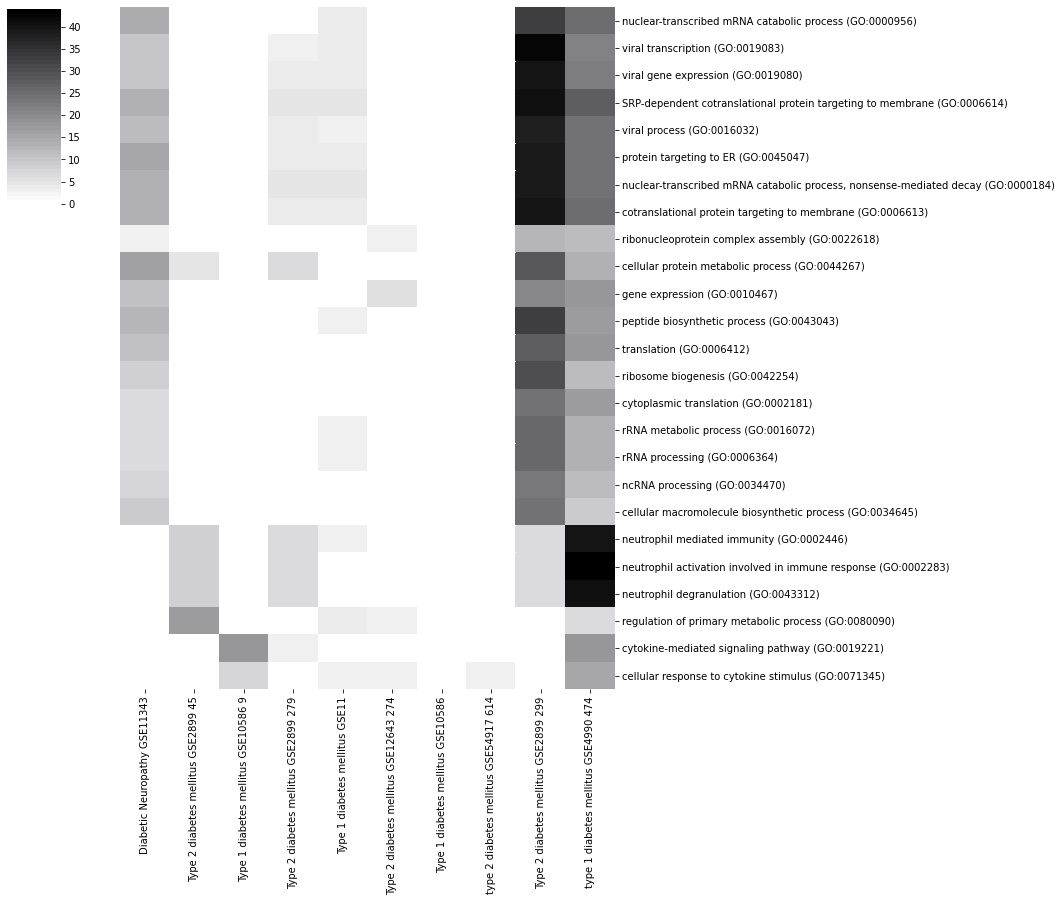

**Figure 2** Heatmap for the top 25 consensus terms for GO Biological Process 2018. [Download figure](GO_Biological_Process_2018_consensus.svg)

<AxesSubplot:xlabel='-log(p)'>

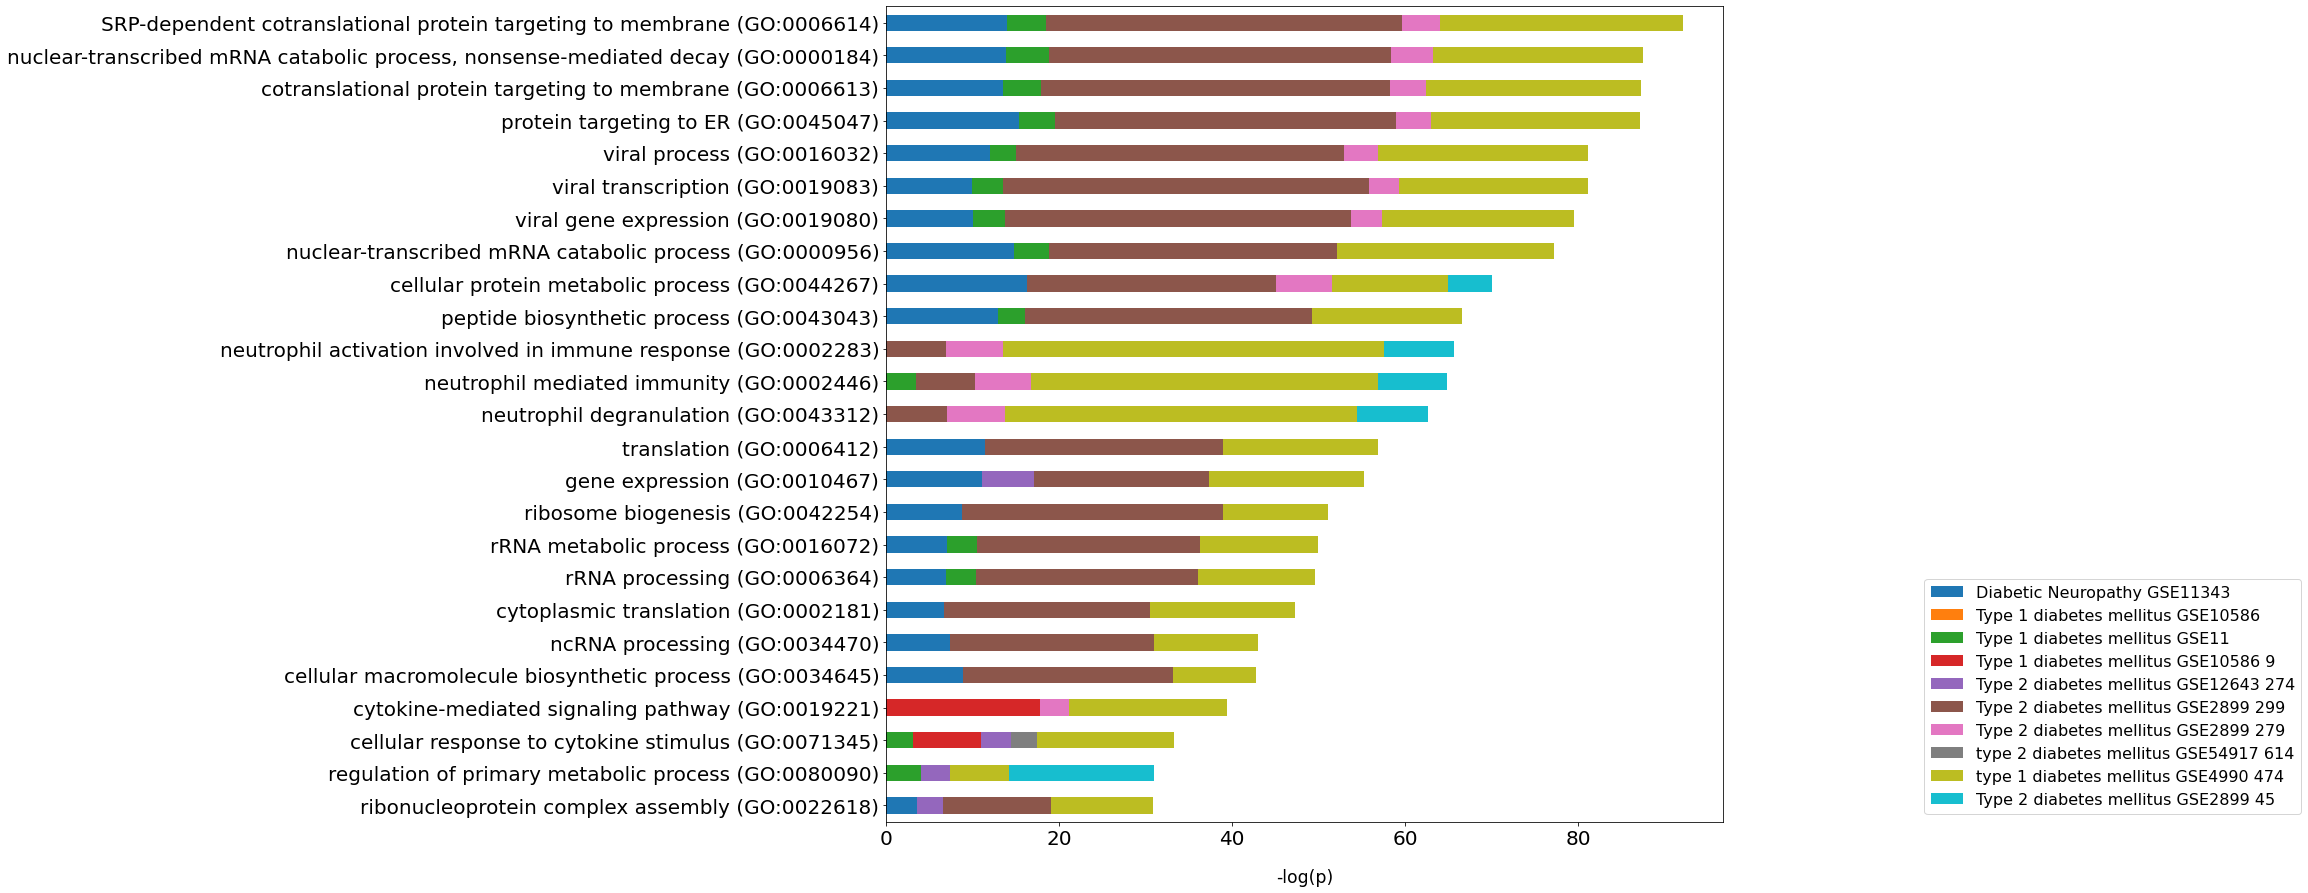

**Figure 3** Stacked bar plot for the top 25 consensus terms for **GO Biological Process 2018**. [Download figure](GO_Biological_Process_2018_consensus_barplot.svg)

In [19]:
for lib in libraries:
    display(Markdown("## %s"%lib.replace("_"," ")), display_id="title_%s"%lib)
    term_df,table = get_dataframe(enrichment, lib, table, display_id=lib)
    consensus, table = get_consensus(term_df, lib, top_results, table, display_id=lib)
    # Visualize
    consensus_df = term_df.loc[consensus.index]
    if (consensus_df.shape[1] > 0):
        clustergram_filename = "%s_consensus_clust.tsv"%lib
        clustergram_caption = "Clustergrammer for the top %d consensus terms for %s "%(top_results, lib.replace("_"," "))
        
        clustergrammer(consensus_df,
                       clustergram_filename,
                       clustergrammer_url,
                       lib,
                       figure, 
                       clustergram_caption,
                      )
        figure+=1
        results_count = len(consensus.index) if len(consensus.index) < top_results else top_results
        heatmap(consensus_df, "%s_consensus.svg"%lib, lib, width, height)
        display(Markdown("**Figure %d** Heatmap for the top %d consensus terms for %s. [Download figure](%s_consensus.svg)"%(figure, results_count, lib.replace("_"," "), lib)), 
                display_id="heatmap_caption_%s"%lib)
        figure+=1
#         if num_sigs <=15:
        status = stackedBarPlot(consensus_df, "%s_consensus_barplot.svg"%lib, display_id=lib)
        if status:
            display(Markdown("**Figure %d** Stacked bar plot for the top %d consensus terms for **%s**. [Download figure](%s_consensus_barplot.svg)"%(figure, top_results, lib.replace("_"," "), lib)), 
                    display_id="stacked_bar_caption_%s"%lib)
            figure +=1 
            
    else:
        print("No terms found")

## References

[1] Chen EY, Tan CM, Kou Y, Duan Q, Wang Z, Meirelles GV, Clark NR, Ma'ayan A. Enrichr: interactive and collaborative HTML5 gene list enrichment analysis tool. BMC Bioinformatics. 2013;128(14).

[2] Kuleshov MV, Jones MR, Rouillard AD, Fernandez NF, Duan Q, Wang Z, Koplev S, Jenkins SL, Jagodnik KM, Lachmann A, McDermott MG, Monteiro CD, Gundersen GW, Ma'ayan A. Enrichr: a comprehensive gene set enrichment analysis web server 2016 update. Nucleic Acids Research. 2016; gkw377.

[3] Fernandez, N. F. et al. Clustergrammer, a web-based heatmap visualization and analysis tool for high-dimensional biological data. Sci. Data 4:170151 doi: 10.1038/sdata.2017.151 (2017).